In [84]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from dataloaders.nascar import NascarDataLoader
from models.VRSLDS import VRSLDS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load NASCAR dataset

25000
torch.Size([4, 200, 10])
torch.Size([4, 200, 2])
torch.Size([4, 200])


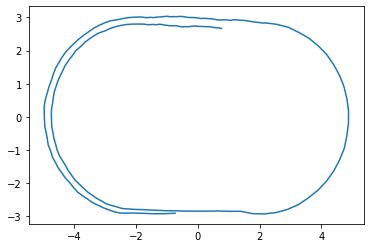

In [91]:
dl = NascarDataLoader('/data2/users/cb221/nascar.npz', 200)
print(len(dl))
train_loader = torch.utils.data.DataLoader(dl, batch_size=4, shuffle=True)
y, x, z = next(iter(train_loader))
print(y.size())
print(x.size())
print(z.size())
plt.plot(x[0,:,0], x[0,:,1])

In [92]:
vrslds = VRSLDS(obs_dim=10, discr_dim=4, cont_dim=2, hidden_dim=128, num_rec_layers=5, SB=True).float()
print(vrslds)
checkpoint = torch.load('/data2/users/cb221/stored_models_vrslds/nascar_5_lstm_seq_len_200_bidir_10_beta_reversed_kl_latest.pth.tar', map_location=torch.device('cpu'))
vrslds.load_state_dict(checkpoint['vrnn'])

VRSLDS(
  (encoder): SequentialEncoder(
    (lstm_encoder): LSTM(10, 128, num_layers=5, batch_first=True, bidirectional=True)
    (out_discr): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=4, bias=True)
    )
    (out_cont_mean): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=2, bias=True)
    )
    (out_cont_log_var): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (C): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=2, out_features=10, bias=True)
    (2): Linear(in_features=2, out_

<All keys matched successfully>

In [93]:
y_pred, x_sample, z_sample, elbo = vrslds(y.float())
z_distr, x_mean, x_log_var = vrslds._inference(y.float())
print(y_pred.size())
print(x_sample.size())
print(z_sample.size())
print(elbo)
x_sample = x_sample.detach()
pred_states = z_sample.argmax(-1)
print(pred_states)
print(z)
print(F.mse_loss(y_pred,y))

torch.Size([4, 200, 10])
torch.Size([4, 200, 2])
torch.Size([4, 200, 4])
{'kld': tensor(286.3507, grad_fn=<AddBackward0>), 'elbo': tensor(739.1085, grad_fn=<AddBackward0>), 'loss': tensor(739.1085, grad_fn=<AddBackward0>)}
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1,

In [94]:
print(z_distr[0])

tensor([[-4.5625e+00,  4.5720e-01,  1.3327e+01, -1.0579e+01],
        [-4.7710e+00,  3.0051e-01,  1.4073e+01, -1.1093e+01],
        [-4.9823e+00,  4.0508e-01,  1.4462e+01, -1.1433e+01],
        [-5.2216e+00,  7.8280e-01,  1.4485e+01, -1.1572e+01],
        [-5.4592e+00,  1.3540e+00,  1.4260e+01, -1.1604e+01],
        [-5.7054e+00,  2.1913e+00,  1.3755e+01, -1.1571e+01],
        [-5.9855e+00,  3.3461e+00,  1.2984e+01, -1.1522e+01],
        [-6.3813e+00,  4.9742e+00,  1.1707e+01, -1.1489e+01],
        [-6.6452e+00,  6.8143e+00,  1.0160e+01, -1.1424e+01],
        [-6.7741e+00,  8.5363e+00,  8.6392e+00, -1.1313e+01],
        [-6.6473e+00,  1.0476e+01,  6.8712e+00, -1.1179e+01],
        [-6.1884e+00,  1.2716e+01,  4.7057e+00, -1.1110e+01],
        [-5.7980e+00,  1.4614e+01,  2.9111e+00, -1.1105e+01],
        [-5.4769e+00,  1.6218e+01,  1.4296e+00, -1.1123e+01],
        [-5.2027e+00,  1.7567e+01,  1.7094e-01, -1.1225e+01],
        [-4.9743e+00,  1.8737e+01, -9.7639e-01, -1.1370e+01],
        

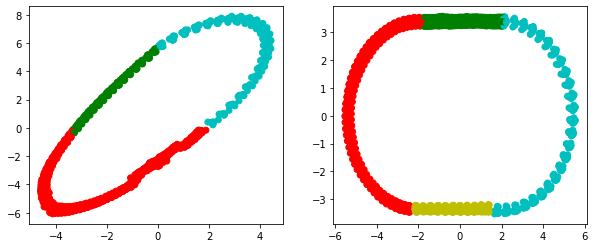

In [88]:
b=1
colors = np.array(['c', 'r', 'g', 'y'])
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_sample[b,:,0], x_sample[b,:,1], color=colors[pred_states[b]])
plt.subplot(122)
plt.scatter(x[b,:,0], x[b,:,1], color=colors[z[b]])
plt.show()

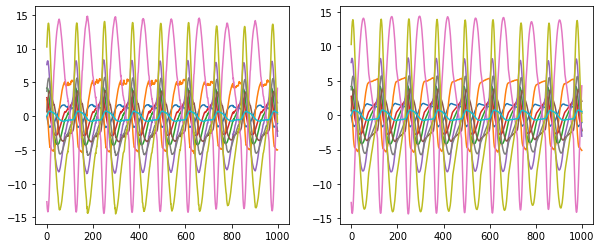

In [89]:
plt.figure(figsize=(10,4))
plt.subplot(121)
for i in range(10):
    plt.plot(y_pred[b,:,i].detach())
plt.subplot(122)
for i in range(10):
    plt.plot(y[b,:,i].detach())
plt.show() 